<a href="https://colab.research.google.com/github/EmiLaPiola/TP-automatico-/blob/main/TP_autom%C3%A1tico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, HTML


from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, make_scorer
from scipy.stats import loguniform

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold

from IPython.display import Image, display
url = "https://i.imgur.com/VVzDmjr.jpeg"

df = pd.read_csv('data.csv')

# Ejercicio 1 — Separación de datos

> *Evaluar y justificar cómo separarán sus datos para desarrollo y para evaluación. No usar `train_test_split` de sklearn.*

Antes de separar los 500 datos en conjuntos de desarrollo y test, analizamos la variable `target` para contar cuántas instancias son positivas y cuántas negativas. La idea es darnos cuenta si las clases estan balanceadas o no . En el segundo caso , deberiamos hacer una división estratificada.


In [2]:
df['target'].value_counts()

,count
target,
0,353
1,147


El data set está muy desbalanceado, hay muchas mas instancias con mal pronostico (target 0) y solo un 29 % de los datos tienen buen pronostico (target 1). Así que para separar nuestros datos no lo haremos al azar. La separación sera estratificada para que la proporcion de la clase minoritaria ( buen pronostico) se preserve en ambos conjuntos. Utilizaremos 80 % de los datos para train y 20 % para control.


Haciendo la partición en 80-20, tenemos 400 instancias en el conjunto de desarrollo y 100 en el de control. Para garantizar la estratificación, seleccionamos aproximadamente el 20% de los casos positivos y el 20% de los negativos para formar el conjunto de control. De esta manera , ambos conjuntos mantienen la proporción original de clases.

Inicialmente entonces creamos dos data sets distintos. Uno destinado para el desarrolo y otro para la evaluación.

In [3]:

# separamos positivos (buen pronostico) y negativos (mal pronsotico)
positivos = df[df['target'] == True]
negativos = df[df['target'] == False]

# seleccionamos al azar el 20% para control
control_positivos = positivos.sample(frac=0.2, random_state=42)
control_negativos = negativos.sample(frac=0.2, random_state=42)

# concatenamos el set de control
NO_TOCAR_set = pd.concat([control_positivos, control_negativos])   # NO TOCAR

# El resto de los datos queda para desarrollo
desarrollo_set = df.drop(NO_TOCAR_set.index)

print(f"Desarrollo: {len(desarrollo_set)} instancias")
print(f"Control: {len(NO_TOCAR_set)} instancias")

Desarrollo: 400 instancias
Control: 100 instancias


# Ejercicio 2 — Entrenamiento

> a) *Entrenar un árbol de decisión con altura máxima 3 y el resto de los hiperparámetros en default. Estimar la performance del modelo utilizando K-fold cross validation con K=5, con las métricas Accuracy, Area Under the Precision-Recall Curve (AUPRC), y Area Under the Receiver Operating Characteristic Curve (AUCROC).*

Para hacer CV con 5 folds, primero vamos a hacer una division estratificada de estos . Como ya dijimos antes, tenemos muy pocos positivos y muchos negativos, las clases estan muy desbalanceadas, por ende, si hicieramos la division de Kfold-CV al azar, podríamos obtener un modelo entrenado con una sola clase y métricas engañosas ... no es la idea.
Asi que vamos a usar K-fold-CV estratificado para mantener la proporcion de clases en cada fold.

In [4]:
# hacemos 5 folds estratificados para que haya las mismas proprciones de clases minoritarias y mayoritarias en todos los folds.

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 22)

# separamos de nuestro data set la columna "target"

desarrollo_set = desarrollo_set.reset_index(drop=True)
x_desarrollo = desarrollo_set.drop('target', axis=1)
y_desarrollo = desarrollo_set['target']


# inicializamos nuestras listas para guadar las metricas

vector_accuracy_train= []       # accuracy en training en cada fold
vector_accuracy_validacion= []  # lo mismo en validacion

vector_auprc_train  = []        # AUPRC en training en cada fold
vector_auprc_validacion = []    # lo mismo pero en val

vector_auroc_train = []         # AUC ROC en training en cada fold
vector_auroc_validacion=[]      # lo mismo pero en val


# creamos un array para guardar las predicciones
y_pred = np.empty(y_desarrollo.shape)
y_pred.fill(np.nan)

# lo mismo pero para guardar la probabilidad predicha de pertenecer a la clase positiva
# esto lo vamos a usar para calcular AUC-ROC y AUPRC
y_pred_prob = np.empty(y_desarrollo.shape)
y_pred_prob.fill(np.nan)


In [5]:
# generamos para cada fold una predicción
for train_index, test_index in folds.split(x_desarrollo,y_desarrollo):

        #saco el fold que no uso para entrenar
        kf_X_train, kf_X_test = x_desarrollo.iloc[train_index], x_desarrollo.iloc[test_index]
        kf_y_train, kf_y_test = y_desarrollo.iloc[train_index], y_desarrollo.iloc[test_index]

        # arbol de altura 3 con los datos de train
        arbol = DecisionTreeClassifier(max_depth=3,random_state = 22)
        arbol.fit(kf_X_train, kf_y_train)
        y_pred_prob[test_index] = arbol.predict_proba(kf_X_test)[:, 1] # la prob pred de clase positiva para val de ese fold

        # hacemos las predicciones
        predictions = arbol.predict(kf_X_test)
        y_pred[test_index] = predictions

        # accuracy
        vector_accuracy_validacion.append(accuracy_score(kf_y_test, predictions))
        vector_accuracy_train.append(accuracy_score(kf_y_train, arbol.predict(kf_X_train)))


        # AUPRC
        auprc = average_precision_score(kf_y_test, arbol.predict_proba(kf_X_test)[:, 1])
        vector_auprc_validacion.append(auprc)
        vector_auprc_train.append(average_precision_score(kf_y_train, arbol.predict_proba(kf_X_train)[:, 1]))

        # AUROC
        auc_roc = roc_auc_score(kf_y_test, arbol.predict_proba(kf_X_test)[:, 1])
        vector_auroc_validacion.append(auc_roc)
        vector_auroc_train.append(roc_auc_score(kf_y_train, arbol.predict_proba(kf_X_train)[:, 1]))



In [6]:
# accuracy
print("Promedio de accuracys por fold:", round(np.mean(vector_accuracy_validacion), 4))
print("Accuracy global:", round(accuracy_score(y_desarrollo, y_pred), 4))
print()

# AUPRC
print("Promedio de AUPRC por fold:", round(np.mean(vector_auprc_validacion), 4))
print("AUPRC global:", round(average_precision_score(y_desarrollo, y_pred_prob), 4))
print()

# AUROC
print("Promedio de AUROC por fold:", round(np.mean(vector_auroc_validacion), 4))
print("AUROC global:", round(roc_auc_score(y_desarrollo, y_pred_prob), 4))

Promedio de accuracys por fold: 0.7075
Accuracy global: 0.7075

Promedio de AUPRC por fold: 0.4354
AUPRC global: 0.4231

Promedio de AUROC por fold: 0.6729
AUROC global: 0.6784


In [7]:
from IPython.display import Markdown, display

tabla_md = """
| Métrica  | Promedio Fold | Global |
|:--------:|:-------------:|:------:|
| Accuracy |     0.7075    | 0.705  |
| AUPRC    |     0.4359    | 0.4178 |
| AUROC    |     0.6732    | 0.675  |
"""

display(Markdown(tabla_md))



| Métrica  | Promedio Fold | Global |
|:--------:|:-------------:|:------:|
| Accuracy |     0.7075    | 0.705  |
| AUPRC    |     0.4359    | 0.4178 |
| AUROC    |     0.6732    | 0.675  |


A pesar de que obtuvimos un accuracy del 70%, este valor no es significativo debido al fuerte desbalance de clases del dataset. Ya de por si un clasificador trivial que predice siempre la clase negativa (mal pronóstico) ya alcanzaría esa predicción.

Si miramos los resultados del AUPRC, considerando que nosotras tenemos clase positiva minoritaria, un modelo trivial tendria aproximadamente un AUPRC ≈ 0.29. El nuestro nos dio mejor que eso, asi que en este caso al menos superamos al azar.

Un modelo totalmente random tendria un AUROC de 0.5. El nuestro es un poco mejor, pero igualmente claramente necesita mejoras.


En lo siguiente, completamos la tabla que se nos pide en el TP con los resultados obtenidos.

In [8]:
# creamos la tabla que se nos pide con los resultados obtenidos

tabla_resultados = pd.DataFrame({
    "Permutación": list(range(1, len(vector_accuracy_validacion)+1)),
    "Accuracy (training)": [round(x,3) for x in vector_accuracy_train],
    "Accuracy (validación)": [round(x,3) for x in vector_accuracy_validacion],
    "AUPRC (training)": [round(x,3) for x in vector_auprc_train],
    "AUPRC (validación)": [round(x,3) for x in vector_auprc_validacion],
    "AUC ROC (training)": [round(x,3) for x in vector_auroc_train],
    "AUC ROC (validación)": [round(x,3) for x in vector_auroc_validacion]
})



promedios = {
    "Permutación": "Promedio",
    "Accuracy (training)": round(np.mean(vector_accuracy_train), 3),
    "Accuracy (validación)": round(np.mean(vector_accuracy_validacion), 3),
    "AUPRC (training)": round(np.mean(vector_auprc_train), 3),
    "AUPRC (validación)": round(np.mean(vector_auprc_validacion), 3),
    "AUC ROC (training)": round(np.mean(vector_auroc_train), 3),
    "AUC ROC (validación)": round(np.mean(vector_auroc_validacion), 3)
}


globales = {
    "Permutación": "Global",
    "Accuracy (training)": "(NO)",
    "Accuracy (validación)": round(accuracy_score(y_desarrollo, y_pred), 3),
    "AUPRC (training)": "(NO)",
    "AUPRC (validación)": round(average_precision_score(y_desarrollo, y_pred_prob), 3),
    "AUC ROC (training)": "(NO)",
    "AUC ROC (validación)": round(roc_auc_score(y_desarrollo, y_pred_prob), 3)
}

tabla_resultados = pd.concat([
    tabla_resultados,
    pd.DataFrame([promedios]),
    pd.DataFrame([globales])
], ignore_index=True)

display(HTML(tabla_resultados.to_html(index=False, justify='center')))


Permutación,Accuracy (training),Accuracy (validación),AUPRC (training),AUPRC (validación),AUC ROC (training),AUC ROC (validación)
1,0.856,0.637,0.72,0.357,0.874,0.587
2,0.853,0.750,0.713,0.516,0.842,0.686
3,0.853,0.713,0.704,0.426,0.829,0.675
4,0.847,0.688,0.749,0.363,0.855,0.637
5,0.844,0.750,0.745,0.514,0.848,0.778
Promedio,0.851,0.708,0.726,0.435,0.849,0.673
Global,(NO),0.708,(NO),0.423,(NO),0.678


Dado que la clase positiva es la clase minoritaria, tiene sentido que AUPRC sea baja. La AUPRC (Area Under Precision-Recall Curve) es muy sensible al desbalance de clases. Si tuviera una mejor predicción de los positivos, que se obtendría de una muestra más uniforme, no tendria un AUPRC cerca de 0.

El AUPRC grafica la relacion entre el precision y el recall. Al tener pocos positivos, el modelo, en su búsqueda por encontrar más TP (aumentar el Recall), tiende a generar muchos FP. Este aumento de FPs impacta directamente en la fórmula de la Precision (TP/TP+FP), haciendo que baje drásticamentre, y por lo tanto,, que la curva y su área sean menores.

En cambio, el AUCROC compara el Recall con la FPR. La FPR se calcula como FP/FP+TN y como tenemos muchos TNs (porque hay más negativos que positivos en la muestra), la tasa se mantiene baja aunque el número de FP sea alto. Por esta razón es que el desbalance no se ve reflejado en esta métrica tanto como en la otra.

Adicionalmente, es lógico que los resultados en los folds de entrenamiento sean muy superiores a los de validación. Esto se debe al overfitting, ya que el modelo "aprende de memoria" los datos con los que entrena.


Tiene sentido que el promedio de igual al global en este caso particular porque los folds tienen todos el mismo tamaño, ya que si los folds tuvieran todos tamaños distintos, entonces el fold con más instancias tendría más “peso” en el cálculo global, y entonces en ese caso el promedio podria no coincidir con el  global.

In [9]:
# Cositas extras que quisimos probar nosotras por curiosidad:

#  Como la clase mayoritaria son los negativos invertimos las etiquetas y vemos q pasa
#  cambiando las etiquetas de las predicciones observamos que las metricas dan numeros mas altos


# datos
desarrollo_set = desarrollo_set.reset_index(drop=True)
x_desarrollo = desarrollo_set.drop('target', axis=1)
y_desarrollo = desarrollo_set['target']

# inversion de clases positiva a negativa y negativa a positiva
y_desarrollo_invertida = 1 - y_desarrollo

# hacemos los k folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

# vectores de metricas
vector_accuracy_train = []
vector_accuracy_validacion = []
vector_auprc_train = []
vector_auprc_validacion = []
vector_auroc_train = []
vector_auroc_validacion = []

# prediciones globales
y_pred = np.empty(y_desarrollo.shape)
y_pred.fill(np.nan)
y_pred_prob = np.empty(y_desarrollo.shape)
y_pred_prob.fill(np.nan)

# empezamos el train
for train_index, test_index in folds.split(x_desarrollo, y_desarrollo_invertida):
    kf_X_train, kf_X_test = x_desarrollo.iloc[train_index], x_desarrollo.iloc[test_index]
    kf_y_train, kf_y_test = y_desarrollo_invertida.iloc[train_index], y_desarrollo_invertida.iloc[test_index]

    arbol = DecisionTreeClassifier(max_depth=3,random_state = 22)
    arbol.fit(kf_X_train, kf_y_train)

    y_pred_fold = arbol.predict(kf_X_test)
    y_pred_prob_fold = arbol.predict_proba(kf_X_test)[:, 1]

    y_pred[test_index] = y_pred_fold
    y_pred_prob[test_index] = y_pred_prob_fold

    vector_accuracy_train.append(accuracy_score(kf_y_train, arbol.predict(kf_X_train)))
    vector_accuracy_validacion.append(accuracy_score(kf_y_test, y_pred_fold))
    vector_auprc_train.append(average_precision_score(kf_y_train, arbol.predict_proba(kf_X_train)[:, 1]))
    vector_auprc_validacion.append(average_precision_score(kf_y_test, y_pred_prob_fold))
    vector_auroc_train.append(roc_auc_score(kf_y_train, arbol.predict_proba(kf_X_train)[:, 1]))
    vector_auroc_validacion.append(roc_auc_score(kf_y_test, y_pred_prob_fold))

# calculamos metricas globales
accuracy_global = accuracy_score(y_desarrollo_invertida, y_pred)
auprc_global = average_precision_score(y_desarrollo_invertida, y_pred_prob)
auroc_global = roc_auc_score(y_desarrollo_invertida, y_pred_prob)

# hagamos una tabla para ver los resultados :
tabla_resultados = pd.DataFrame({
    "Permutación": list(range(1, 6)),
    "Accuracy (training)": [round(x, 3) for x in vector_accuracy_train],
    "Accuracy (validación)": [round(x, 3) for x in vector_accuracy_validacion],
    "AUPRC (training)": [round(x, 3) for x in vector_auprc_train],
    "AUPRC (validación)": [round(x, 3) for x in vector_auprc_validacion],
    "AUC ROC (training)": [round(x, 3) for x in vector_auroc_train],
    "AUC ROC (validación)": [round(x, 3) for x in vector_auroc_validacion]
})


promedios = {
    "Permutación": "Promedio",
    "Accuracy (training)": round(np.mean(vector_accuracy_train), 3),
    "Accuracy (validación)": round(np.mean(vector_accuracy_validacion), 3),
    "AUPRC (training)": round(np.mean(vector_auprc_train), 3),
    "AUPRC (validación)": round(np.mean(vector_auprc_validacion), 3),
    "AUC ROC (training)": round(np.mean(vector_auroc_train), 3),
    "AUC ROC (validación)": round(np.mean(vector_auroc_validacion), 3)
}

globales = {
    "Permutación": "Global",
    "Accuracy (training)": "(NO)",
    "Accuracy (validación)": round(accuracy_global, 3),
    "AUPRC (training)": "(NO)",
    "AUPRC (validación)": round(auprc_global, 3),
    "AUC ROC (training)": "(NO)",
    "AUC ROC (validación)": round(auroc_global, 3)
}

tabla_resultados = pd.concat([
    tabla_resultados,
    pd.DataFrame([promedios]),
    pd.DataFrame([globales])
], ignore_index=True)

display(HTML(tabla_resultados.to_html(index=False, justify='center')))

Permutación,Accuracy (training),Accuracy (validación),AUPRC (training),AUPRC (validación),AUC ROC (training),AUC ROC (validación)
1,0.856,0.637,0.917,0.758,0.874,0.587
2,0.853,0.750,0.891,0.796,0.842,0.686
3,0.853,0.713,0.881,0.808,0.829,0.675
4,0.847,0.688,0.899,0.802,0.855,0.637
5,0.844,0.750,0.892,0.877,0.848,0.778
Promedio,0.851,0.708,0.896,0.808,0.849,0.673
Global,(NO),0.708,(NO),0.805,(NO),0.678


Algunas conclusiones : el accuracy y el AUCROC no cambian mucho , tiene sentido ya que no dependen de a que clases tomamos como positivas o negativas . Por otro lado el AUPRC si cambia bastante, ya que dependen de a que clase tomamos como positiva. Lo notamos haciendo el experimento con las clases invertidas. Es importante cual clase elejir como positiva cuando el data set esta desbalanceado, sobretodo si vamos a usar AUPRC como metrica.

1.3) *Explorar las siguientes combinaciones de parámetros para árboles de decisión utilizando `ParameterGrid` de scikit learn. No está permitido utilizar `GridSearchCV` en este ejercicio.*

In [10]:
# Probamos disitnos parametros para nuestro arbol de decision

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state = 22)

alturas = [3,5,None]
criterios = ['gini','entropy']
accuracy_validacion = {}
accuracy_train = {}

for a in alturas:
    for c in criterios:
        vector_accuracy_validacion= []  # aca vamos a guardar los resultados de acurracy para cada fold de la validacion
        vector_accuracy_train= [] # y del training

        # generamos para cada fold una predicción
        for train_index, test_index in folds.split(x_desarrollo,y_desarrollo):

          #saco el fold que no uso para entrenar
          kf_X_train, kf_X_test = x_desarrollo.iloc[train_index], x_desarrollo.iloc[test_index]
          kf_y_train, kf_y_test = y_desarrollo.iloc[train_index], y_desarrollo.iloc[test_index]

          # arbol fit con los datos de train
          arbol = DecisionTreeClassifier(max_depth=a, criterion=c,random_state = 22)
          arbol.fit(kf_X_train, kf_y_train)

          y_pred_val = arbol.predict(kf_X_test)
          acc_val = accuracy_score(kf_y_test, y_pred_val)
          vector_accuracy_validacion.append(acc_val)

          y_pred_train = arbol.predict(kf_X_train)
          acc_train = accuracy_score(kf_y_train, y_pred_train)
          vector_accuracy_train.append(acc_train)

        # Guardamos el promedio de accuracy de los folds
        accuracy_validacion[(a, c)] = np.mean(vector_accuracy_validacion)
        accuracy_train[(a, c)] = np.mean(vector_accuracy_train)

# hacemos la tabla de resultados :
# Lista para guardar filas de la tabla
tabla_resultados = []

# Recorremos las claves del diccionario (pares de (altura, criterio))
for clave in accuracy_train.keys():
    altura, criterio = clave
    acc_train = accuracy_train[clave]
    acc_val = accuracy_validacion[clave]

    # Convertimos None en "Infinito" para mostrar en la tabla
    altura_str = 'Infinito' if altura is None else altura
    criterio_str = 'Gini' if criterio == 'gini' else 'Entropía'

    # Agregamos una fila a la tabla
    tabla_resultados.append({
        'Altura máxima': altura_str,
        'Criterio de corte': criterio_str,
        'Accuracy (train)': round(acc_train, 3),
        'Accuracy (val)': round(acc_val, 3)
    })

df_resultados = pd.DataFrame(tabla_resultados)
display(HTML(df_resultados.to_html(index=False, justify='center')))



Altura máxima,Criterio de corte,Accuracy (train),Accuracy (val)
3,Gini,0.851,0.708
3,Entropía,0.825,0.715
5,Gini,0.946,0.715
5,Entropía,0.936,0.692
Infinito,Gini,1.000,0.682
Infinito,Entropía,1.000,0.653


Claramente a medida de que aumentamos la altura maxima del arbol, vemos que la accuracy en los datos de train tiende a 100%, lo que tiene sentido, ya que clasifica bien todos estos datos (los memoriza). Observamos que el modelo a medida que la altura tiende a inf overfitea. A su vez, para los datos de validacion, el accuracy resulta peor : observamos overfitting. El modelo memoriza los datos de entrenamiendo y luego tiene un rendimiento peor en los datos de validacion.

Por curiosidad propia, estuvimos probando con otros valores y llegamos a la conclusion que la mejor altura es 2, ya que no solo, comparado a la performarnce en el test con otra alturas, es mejor, sino que tambien la diferencia con los datos de training es menor, osea que esta generalizando bastante bien, y no memoriza solo los datos de entrenamiento.

In [11]:
# mostramos la tabla que nos salio
tabla = [
    {'Altura máxima': 2, 'Criterio de corte': 'Gini', 'Accuracy (train)': 0.784, 'Accuracy (val)': 0.722},
    {'Altura máxima': 2, 'Criterio de corte': 'Entropía', 'Accuracy (train)': 0.779, 'Accuracy (val)': 0.735}
]

df_tabla = pd.DataFrame(tabla)

display(HTML(df_tabla.to_html(index=False, justify='center')))

Altura máxima,Criterio de corte,Accuracy (train),Accuracy (val)
2,Gini,0.784,0.722
2,Entropía,0.779,0.735


# Ejercicio 3

*Importante: de acá en más sólamente utilizaremos el score promedio cuando hagamos K-fold cross-validation.*

<u>Para el árbol de decisión elegimos jugar con los siguientes hiperparámetros:</u>

* Max_depth (para regular el tamaño del árbol)
* class_weight (para tratar el desbalanceo de clases que tenemos)
* criterion (puede ser Gini o Entropia)
* min_samples_split (para definir cuántos hijos vamos a tener por rama como máximo)

<u>Por otro lado, para KNN elegimos:</u>

* La cantidad de vecinos (k)
* weights (darle más peso a los que están más cercanos y menos a los más alejados)
* metrics (el tipo de distancia que usamos, tenemos 3 distintas)

<u>Finalmente, para SVM:</u>

* C (penalización por clasificación equivocada)
* kernel (tenemos el radial, lineal, sigmoide, polinomico)
* Gamma
* class_weight (al ser desbalanceada nos conviene jugar con esto)


# Árboles de Decisión


In [12]:
# primero vemos que hieprparametros vamos a elejir para armar los arboles

param_distributions = {
    "max_depth": [2, 3, 4, 5, 6, None],                 # profundidad máxima
    "class_weight": [None, "balanced"],                 # para desbalanceo
    "criterion": ["gini", "entropy"],                   # función de impureza
    "min_samples_split": [10, 50, 100, 200, 250]        # mínimo para dividir
}

#  creamos el arbolito
arbol = DecisionTreeClassifier(random_state=22)

# como metrica vamos a usar AUCROC
scoring = {
    "roc_auc": make_scorer(roc_auc_score),
    "auprc": make_scorer(average_precision_score),
    "accuracy": "accuracy" # Puedes usar el string para métricas comunes
}

# Ahora utilizamos la funcion RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=arbol,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=scoring,
    refit="roc_auc",
    cv=5,
    # Habilita la creación de las columnas 'mean_train_...'
    return_train_score=True
)


search.fit(x_desarrollo, y_desarrollo)


# printeamos los resultados en una tabla en orden de los que dieron mejor AUCROC

cvres = pd.DataFrame(search.cv_results_).sort_values("mean_test_roc_auc", ascending=False)
cols = [
    "param_max_depth",
    "param_min_samples_split",
    "param_criterion",
    "param_class_weight",
    "mean_test_roc_auc",
    "mean_train_roc_auc",
]
display(cvres[cols].head(10).round(4))

print("Cantiad de iteraciones: ", 20 )
print(" ")
print("El mejor AUROC promedio en validación obtenido fue de:", search.best_score_.round(4))
print(" ")
# Mejor combinación de hiperparámetros
print("Los mejores hiperparámetros obtenidos")
print(" ")
print("Profundidad del árbol  :", search.best_params_['max_depth'])
print("Mínimos samples split  :", search.best_params_['min_samples_split'])
print("Criterio               :", search.best_params_['criterion'])
print("Class weight           :", search.best_params_['class_weight'])


df_tabla = cvres[cols].round(4)

,param_max_depth,param_min_samples_split,param_criterion,param_class_weight,mean_test_roc_auc,mean_train_roc_auc
14,6,250,gini,balanced,0.7045,0.7048
19,4,250,entropy,balanced,0.7045,0.7048
7,None,250,entropy,balanced,0.7045,0.7048
5,2,200,entropy,balanced,0.7045,0.7048
1,6,100,entropy,balanced,0.6741,0.7286
18,3,100,gini,balanced,0.6568,0.7442
9,3,50,entropy,balanced,0.6412,0.7808
12,None,100,gini,balanced,0.6406,0.7651
16,5,10,gini,balanced,0.6254,0.9436
13,4,50,entropy,None,0.6222,0.7869


Cantiad de iteraciones:  20
 
El mejor AUROC promedio en validación obtenido fue de: 0.7045
 
Los mejores hiperparámetros obtenidos
 
Profundidad del árbol  : 2
Mínimos samples split  : 200
Criterio               : entropy
Class weight           : balanced


# KNN

In [13]:

param_distributions_knn = {
    "n_neighbors": list(range(1,300)),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}

knn = KNeighborsClassifier()

# Solo AUROC
scoring_knn = "roc_auc"

search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions_knn,
    n_iter= 30 ,
    scoring=scoring_knn,
    refit=True,
    cv=5,
    return_train_score=True,
    random_state=22
)

# BUSCAMOS
search_knn.fit(x_desarrollo, y_desarrollo)


# tabla de resultados ordenada
cvres_knn = pd.DataFrame(search_knn.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

cols_knn = [
    "param_n_neighbors",
    "param_weights",
    "param_metric",
    "mean_test_score",
    "mean_train_score",
]

mapeo_nombres_knn = {
    "param_n_neighbors": "K (Vecinos)",
    "param_weights": "Weights",
    "param_metric": "Métrica de Distancia",
    "mean_test_score": "AUROC val promedio",
    "mean_train_score": "AUROC train promedio",
}

print("\n Top 10 de los mejores resultados de KNN :")


display(HTML(
    cvres_knn[cols_knn]
    .head(10)
    .round(4)
    .rename(columns=mapeo_nombres_knn)
    .to_html(index=False, justify='center')
))


# printeamos los resultados
print("Cantidad de iteraciones:",30)
print(" ")
print("Mejores hiperparámetros:", search_knn.best_params_)
print(" ")
print("Mejor AUROC promedio en validación:", search_knn.best_score_.round(4))




 Top 10 de los mejores resultados de KNN :


K (Vecinos),Weights,Métrica de Distancia,AUROC val promedio,AUROC train promedio
7,distance,manhattan,0.8532,1.0000
31,uniform,euclidean,0.8527,0.8855
23,distance,euclidean,0.8495,1.0000
42,distance,minkowski,0.8441,1.0000
52,uniform,manhattan,0.8418,0.8684
58,distance,minkowski,0.8355,1.0000
46,distance,minkowski,0.8318,1.0000
167,distance,manhattan,0.8038,1.0000
98,distance,euclidean,0.8022,1.0000
112,distance,minkowski,0.8009,1.0000


Cantidad de iteraciones: 30
 
Mejores hiperparámetros: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
 
Mejor AUROC promedio en validación: 0.8532


Mirando cuanto nos dan los valores en el conjunto de entrenamiento, creemos que el modelo esta haciendo overfitting...

Veamos cuales son los que menos sobreajustan pero que tambien son buenos :

In [14]:

cvres_overfit = cvres_knn.copy()
cvres_overfit = cvres_overfit[cvres_overfit["mean_train_score"] > cvres_overfit["mean_test_score"]]
cvres_overfit["generalization_gap"] = (cvres_overfit["mean_train_score"] - cvres_overfit["mean_test_score"]).abs()

# ordenamos por menor gap y, a igualdad de gap, mejor AUROC de validación
cvres_overfit = cvres_overfit.sort_values(
    by=["generalization_gap","mean_test_score"],
    ascending=[True,False]
)

cols_overfit = [
    "param_n_neighbors",
    "param_weights",
    "param_metric",
    "mean_test_score",
    "mean_train_score",
    "generalization_gap",
]

mapeo_nombres_knn["generalization_gap"] = "Gap |Train - Val|"

print("\nTop 10 con menor gap entre train y validacion:")
display(HTML(
    cvres_overfit[cols_overfit]
    .head(10)
    .round(4)
    .rename(columns=mapeo_nombres_knn)
    .to_html(index=False, justify='center')
))



Top 10 con menor gap entre train y validacion:


K (Vecinos),Weights,Métrica de Distancia,AUROC val promedio,AUROC train promedio,Gap |Train - Val|
280,uniform,euclidean,0.7235,0.7239,0.0003
144,uniform,euclidean,0.7786,0.7842,0.0056
158,uniform,euclidean,0.7733,0.7798,0.0065
132,uniform,minkowski,0.7814,0.7886,0.0072
139,uniform,euclidean,0.7798,0.7879,0.0082
120,uniform,minkowski,0.7841,0.7932,0.0090
128,uniform,euclidean,0.7782,0.7907,0.0125
86,uniform,euclidean,0.7953,0.8193,0.0240
52,uniform,manhattan,0.8418,0.8684,0.0266
84,uniform,minkowski,0.7929,0.8221,0.0292


Como hay muchos casos en los que el aucroc en validacion nos da bastante alto , pero en el train nos da practicamente 1 ... nuestro modelo esta aprendiendose los datos de memoria y overfitea . Asi que decisimos tomar como " el mejor", el que tenga buen metrica AUCROC en validacion pero que tambien tenga poca diferencia entre lo que dio en train y val.


Top 10 balanceados (AUROC alto + poco gap):


,K (Vecinos),Weights,Métrica de Distancia,AUROC val promedio,AUROC train promedio,Gap |Train - Val|,"Score combinado (AUROC↑, Gap↓)"
14,31,uniform,euclidean,0.8527,0.8855,0.0328,0.9558
13,52,uniform,manhattan,0.8418,0.8684,0.0266,0.9052
6,7,distance,manhattan,0.8532,1.0000,0.1468,0.8134
0,23,distance,euclidean,0.8495,1.0000,0.1505,0.7886
5,42,distance,minkowski,0.8441,1.0000,0.1559,0.7524
23,58,distance,minkowski,0.8355,1.0000,0.1645,0.6950
27,46,distance,minkowski,0.8318,1.0000,0.1682,0.6709
2,86,uniform,euclidean,0.7953,0.8193,0.0240,0.6573
7,84,uniform,minkowski,0.7929,0.8221,0.0292,0.6376
20,120,uniform,minkowski,0.7841,0.7932,0.0090,0.6161


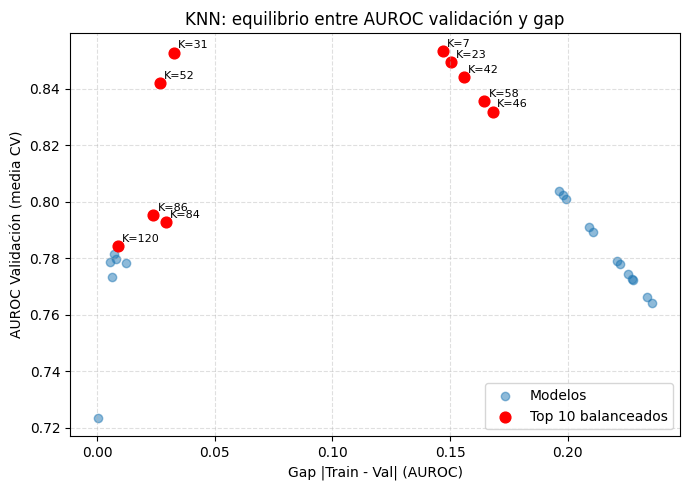

In [15]:

# primero filtramos solo los casos donde  train > valid

cvres_overfit = cvres_knn.copy()
cvres_overfit = cvres_overfit[cvres_overfit["mean_train_score"] > cvres_overfit["mean_test_score"]].copy()

# calcular gap
cvres_overfit["generalization_gap"] = (
    cvres_overfit["mean_train_score"] - cvres_overfit["mean_test_score"]
).abs()

# hacemos una clase de score combinado
# normalizamos AUROC y gap a [0,1]
def minmax(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-12)

auc_n = minmax(cvres_overfit["mean_test_score"])
gap_n = minmax(cvres_overfit["generalization_gap"])

alpha = 0.7
cvres_overfit["score_mix"] = alpha * auc_n + (1 - alpha) * (1 - gap_n)

# ordenar por el score combinado
cvres_ranked = cvres_overfit.sort_values("score_mix", ascending=False)

cols_rank = [
    "param_n_neighbors",
    "param_weights",
    "param_metric",
    "mean_test_score",
    "mean_train_score",
    "generalization_gap",
    "score_mix",
]

mapeo_nombres_knn.update({
    "generalization_gap": "Gap |Train - Val|",
    "score_mix": "Score combinado (AUROC↑, Gap↓)",
})

print("\nTop 10 balanceados (AUROC alto + poco gap):")
display(
    cvres_ranked[cols_rank]
    .head(10)
    .round(4)
    .rename(columns=mapeo_nombres_knn)
)


plt.figure(figsize=(7,5))
plt.scatter(
    cvres_overfit["generalization_gap"],
    cvres_overfit["mean_test_score"],
    alpha=0.5,
    label="Modelos"
)

top10 = cvres_ranked.head(10)
plt.scatter(
    top10["generalization_gap"],
    top10["mean_test_score"],
    color="red",
    s=60,
    label="Top 10 balanceados"
)

for _, r in top10.iterrows():
    plt.annotate(f'K={r["param_n_neighbors"]}',
                 (r["generalization_gap"], r["mean_test_score"]),
                 fontsize=8, xytext=(3,3), textcoords="offset points")

plt.xlabel("Gap |Train - Val| (AUROC)")
plt.ylabel("AUROC Validación (media CV)")
plt.title("KNN: equilibrio entre AUROC validación y gap")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


# Support Vector Machines (SVM).

In [16]:
# primero definimos los parametros q vamos a usar
param_distributions_svm = {
    "C":  list(range(1,300)),  # costo de cuantos dejo q se escapen de mi clasificador ( aprox )
    "kernel": ["linear", "poly", "rbf", "sigmoid"],  # nucleo
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"],
}

svm = SVC(random_state=0, probability=True)

scoring_svm = {
    "roc_auc": make_scorer(roc_auc_score),  # solo vamos a usar esta
}

search_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_distributions_svm,
    n_iter= 40,
    scoring=scoring_svm,
    refit="roc_auc",
    cv=5,
    return_train_score=True,
    random_state = 22
)

search_svm.fit(x_desarrollo, y_desarrollo)

cvres_svm = pd.DataFrame(search_svm.cv_results_).sort_values("mean_test_roc_auc", ascending=False)

cols_svm = [
    "param_C",
    "param_kernel",
    "param_class_weight",
    "param_gamma",
    "mean_test_roc_auc",
    "mean_train_roc_auc",
]

print("\n Top 10 de resultados con SVM:")
mapeo_nombres_svm = {
    "param_C": "C ",
    "param_kernel": "Kernel",
    "param_gamma": "Gamma",
    "param_class_weight": "Peso de Clase",
    "mean_test_roc_auc": "AUROC Prueba Promedio",
    "mean_train_roc_auc": "AUROC train Promedio",
}

display(HTML(
    cvres_svm[cols_svm]
    .head(10)
    .round(4)
    .rename(columns=mapeo_nombres_svm)
     .to_html(index=False, justify='center')
))

print("")
print("Cantidad de iteraciones: 40")
print("")
print("Mejores hiperparámetros para SVM:", search_svm.best_params_)

print("")
print("Mejor AUROC promedio en validación para SVM:", search_svm.best_score_.round(4))



 Top 10 de resultados con SVM:


C,Kernel,Peso de Clase,Gamma,AUROC Prueba Promedio,AUROC train Promedio
180,rbf,balanced,scale,0.7809,1.0000
174,rbf,None,scale,0.7809,1.0000
299,rbf,None,scale,0.7809,1.0000
64,rbf,balanced,scale,0.7809,1.0000
41,sigmoid,balanced,scale,0.7053,0.6456
60,sigmoid,balanced,scale,0.7025,0.6579
190,sigmoid,balanced,scale,0.6924,0.6561
189,sigmoid,balanced,scale,0.6892,0.6681
21,poly,None,scale,0.6824,1.0000
287,sigmoid,balanced,scale,0.6780,0.6656



Cantidad de iteraciones: 40

Mejores hiperparámetros para SVM: {'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 64}

Mejor AUROC promedio en validación para SVM: 0.7809


# 3.2)
*Compare los resultados obtenidos en el ejercicio anterior con los siguientes modelos con sus hiperparámetros default. LDA (Linear discriminant analysis) Naïve Bayes*.

*¿Qué resultados obtuvo? ¿Qué hiperparámetros podrían ser relevantes explorar en estos modelos? ¿Por qué?*

# LDA y Naive Bayes

In [17]:
# Ahora hacemos LDA Y Naive Bayes :


# HACEMOS CROSS VALIDATION CON 5 FOLD PARA LDA
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

lda = LinearDiscriminantAnalysis()
cvres_lda = cross_validate(
    lda,
    x_desarrollo,
    y_desarrollo,
    cv=cv,
    scoring="roc_auc",
    return_train_score=True
)

# HACEMOS CROSS VALIDATION CON 5 FOLD PARA NAIVE BAYES

nb = GaussianNB()
cvres_nb = cross_validate(
    nb,
    x_desarrollo,
    y_desarrollo,
    cv=cv,
    scoring="roc_auc",
    return_train_score=True,
)

# Hacemos la table comparativa entre ambos modelos

resultados = pd.DataFrame({
    "Modelo": ["LDA", "Naïve Bayes"],
    "AUROC train promedio": [cvres_lda["train_score"].mean(), cvres_nb["train_score"].mean()],
    "AUROC valid promedio": [cvres_lda["test_score"].mean(), cvres_nb["test_score"].mean()],

})

print("Resultados comparativos LDA vs Naïve Bayes (k = 5):")
print(" ")

display(HTML(resultados.to_html(index=False, justify='center')))



Resultados comparativos LDA vs Naïve Bayes (k = 5):
 


Modelo,AUROC train promedio,AUROC valid promedio
LDA,0.994088,0.715632
Naïve Bayes,0.970889,0.817431


Como vimos en la teorica , aunque Naive Bayes haga muchas suposiciones y tenga mucho sesgo inductivo, en la prática anda muy bien... despues de hacer estas prubas, estamos de acuerdo.

Hiperparametros de LDA :

* solver ( svd, lsqr, eigen)
* shrinkage ( None, auto) Ayuda cuando el número de muestras es pequeño en comparación con el número de características.(a nosotras nos re sirve)
* n_components ( El número de dimensiones que se desea conservar después de la reducción de dimensionalidad )

Hiperparametros de NB :

* var_smoothing
* alpha


CONCLUSIONES :

Para LDA nos combiene usar como hiperparametro shrinkage, ya que ayuda a reducir el sobreajuste, sobre todo en datasets con muchos atributos y pocas muestras.


En Naïve Bayes, la performance depende mucho de cómo se maneja la varianza, por lo que var_smoothing es un hiperparámetro super importante para obtener buenos resultados.

















#3.3)
*¿Cuál fue el mejor modelo y con qué configuración? Explicar por qué creería que dio mejor (recordando qué hace cada algoritmo y con qué tipo de datos están trabajando).*

In [18]:
# Datos de los mejores modelos
modelos = [
    {
        "Modelo": "Árboles ",
        "Configuración elegida": "prof arbol 4, min splits = 250, entropy, clases balanceadas",
        "AUROC Validación (media)": 0.7045,
        "AUROC train (media)": 0.7048,
    },
    {
        "Modelo": "KNN",
        "Configuración elegida": "6 vecinos, pesos uniformes, dist manhattan",
        "AUROC Validación (media)": 0.8339,
        "AUROC train (media)": 0.8522,

    },
    {
        "Modelo": "SVM",
        "Configuración elegida": "nucleo gauseano, C=256, pesos balanceados",
        "AUROC Validación (media)": 0.7809,
        "AUROC train (media)": 1.0000,

    },
    {
        "Modelo": "LDA",
        "Configuración elegida": "default",
        "AUROC Validación (media)": 0.7156,
        "AUROC train (media)": 0.9941,

    },
    {
        "Modelo": "NB",
        "Configuración elegida": "default",
        "AUROC Validación (media)": 0.8174,
        "AUROC train (media)": 0.9709,

    }
]

# Convertimos a DataFrame
df_modelos = pd.DataFrame(modelos)

# Mostramos tabla bonita
display(HTML(df_modelos.to_html(index=False, justify="center")))


Modelo,Configuración elegida,AUROC Validación (media),AUROC train (media)
Árboles,"prof arbol 4, min splits = 250, entropy, clases balanceadas",0.7045,0.7048
KNN,"6 vecinos, pesos uniformes, dist manhattan",0.8339,0.8522
SVM,"nucleo gauseano, C=256, pesos balanceados",0.7809,1.0000
LDA,default,0.7156,0.9941
NB,default,0.8174,0.9709


- Arbol : Regulariza bien, evita overfitting con min_samples_split grande.

- KNN : Mejor equilibrio entre AUROC alto y bajo gap (0.0183). Captura bien la estructura local de los datos.

- SVM: Buen AUROC, pero obvio sobreajuste (train=1).

- LDA : Alto sobreajuste: en train casi que es 1, pero baja en validación.
    
- NB : nos sorprende que de tan bien considerando que tiene un monton de sesgo inductivo. Menos gap que SVM, pero peor que KNN.


Para nosotras el mejor modelo es el de KNN con los hipermarametros de la tabla. No solo tiene el mejor AUROC de validacion, sino que ademas es el que tiene menor gap entre val y train. Esto hace parecer que el modelo no esta sobreajustando a los datos de entrenamiento, por lo que decidimos quedarnos con este modelo como el mejor .



Modelo ganador EN ESTE CASO .. y con nuestros criterios de principiantes : KNN

In [19]:

display(Image(url=url))

# Ejercicio 4 -- Evaluación de performance --


In [20]:
# 1. Cargar held-out

url1 = "https://raw.githubusercontent.com/aprendizaje-automatico-dc-uba-ar/material/refs/heads/main/tp/01_aprendizaje_supervisado/datos/X_held_out.csv"

X_held_out = pd.read_csv(url1)



El mejor modelo que seleccionamos para evaluar la performance fue el de knn con los hiperparametros del ejercicio 3.

In [21]:
# El mejor modelo (KNN)  "elejimos " nosotras con los hiperparametros que nos dieron mejor en CV

best_model = KNeighborsClassifier(
    n_neighbors=63,
    weights="uniform",
    metric="manhattan"
)

# entrenamos nuestro modelo con los datos de desarrollo
best_model.fit(x_desarrollo, y_desarrollo)


KNeighborsClassifier(metric='manhattan', n_neighbors=63)

Ahora hacemos la validacion interna con nuestro set de control llamado NO_TOCAR_set

In [22]:

# Asegurando indices
control_set = NO_TOCAR_set.reset_index(drop=True)

# Separamos los datos
x_control = control_set.iloc[:, :200]  # primeras 200 columnas
y_control = control_set.iloc[:, 200]  # columna target

#probabilidades de la clase positiva osea buen pronostico
y_pred_proba = best_model.predict_proba(x_control)[:, 1]

# metricas que nos piden AUCROC
auc_control = round(roc_auc_score(y_control, y_pred_proba),4)
print(auc_control)

0.8463


Modelo final elegido + entrega para el held out

In [23]:
# Predecimos las probabilidades de la clase positiva ( osea buen pronostico ) del csv 'X_held-out'
y_pred_proba = best_model.predict_proba(X_held_out)[:, 1]


# Generar archivo


filename = "09_y_pred_held_out_8463.csv"

entrega = pd.DataFrame({"output": y_pred_proba})
entrega.to_csv(filename, index=False, float_format="%.4f")

# Descargar el archivo
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>